In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hyperopt import hp
from fedot_ind.core.architecture.pipelines.abstract_pipeline import AbstractPipeline, ApiTemplate
from fedot_ind.core.repository.constanst_repository import SPECTRUM_ESTIMATORS
from fedot_ind.core.repository.constanst_repository import DISCRETE_WAVELETS, CONTINUOUS_WAVELETS

In [2]:
def plot_mean_sample(X,y, labels:list = [], n_channel: int = 1):
    mean_sample = []
    if len(labels) == 0:
        labels = list(np.unique(y))
    for label in labels:
        mean_sample.append(np.mean(X[y == label] , axis=0)) # Данные класса 1
    #ax = plt.gca()
    channels = [f'Channel {x}' for x in range(n_channel)]
    df = pd.DataFrame(mean_sample).T
    df.columns = labels
    df.plot(kind ='line',subplots=True, layout=(1,len(labels)),figsize=(20,10))
    plt.legend(fontsize='small')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [3]:
def plot_mean_sample_multi(X,y, labels:list = [], n_channel: int = None):
    mean_sample = {}
    if len(labels) == 0:
        labels = list(np.unique(y))
    if n_channel is None:
        n_channel = X.shape[1]
    channels = [f'Channel {x}' for x in range(n_channel)]
    for label in labels:
        mask = y == label
        for chn in range(n_channel):
            mean_sample.update({f'Label_{label}_channel_{chn}':np.mean(X[mask.flatten(),chn,:] , axis=0)}) # Данные класса 1
    #ax = plt.gca()
    df = pd.DataFrame(mean_sample)
    df.plot(kind ='line')
    plt.suptitle('Усреднённые семплы по классам')
    plt.legend(fontsize='small')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [4]:
finetune = False
metric_names = ('f1', 'accuracy', 'precision', 'roc_auc')
api_config = dict(problem='classification',
                  metric='accuracy',
                  timeout=1,
                  pop_size=10,
                  with_tunig=False,
                  n_jobs=2,
                  logging_level=20)
pipeline_creator = AbstractPipeline(task='classification')

# Our datasets and models for experiments

In [152]:
easy_to_clf_uno = 'ItalyPowerDemand'
hard_to_clf_uno = 'ElectricDevices'
easy_to_clf_multi = 'BasicMotions'
hard_to_clf_multi = 'AtrialFibrillation'
node_list_model = ['quantile_extractor','logit']

# Our datasets

In [153]:
easy_to_clf_uno_dataset = pipeline_creator.create_input_data(easy_to_clf_uno)
hard_to_clf_uno_dataset = pipeline_creator.create_input_data(hard_to_clf_uno)
easy_to_clf_multi_dataset = pipeline_creator.create_input_data(easy_to_clf_multi)
hard_to_clf_multi_dataset = pipeline_creator.create_input_data(hard_to_clf_multi)

2024-10-14 17:24:08,554 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\ItalyPowerDemand
2024-10-14 17:24:08,571 - Data read successfully from local folder
2024-10-14 17:24:08,573 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\ElectricDevices
2024-10-14 17:24:09,029 - Data read successfully from local folder
2024-10-14 17:24:09,061 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\BasicMotions
2024-10-14 17:24:09,143 - Data read successfully from local folder
2024-10-14 17:24:09,150 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\AtrialFibrillation
2024-10-14 17:24:09,175 - Data read successfully from local folder


# Lets Visualise our data

## Easy to clf data

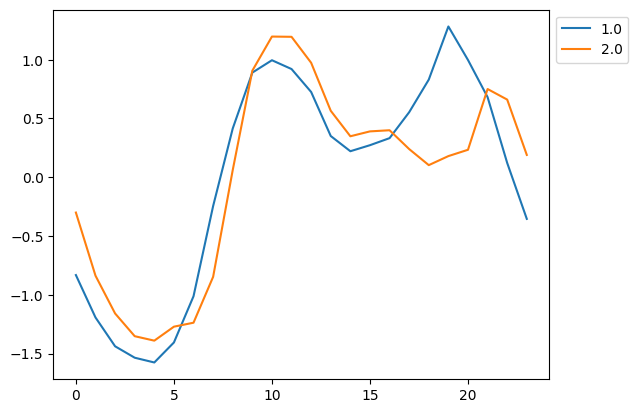

In [154]:
plot_mean_sample(easy_to_clf_uno_dataset[0].features,easy_to_clf_uno_dataset[0].target)

## Hard to clf data

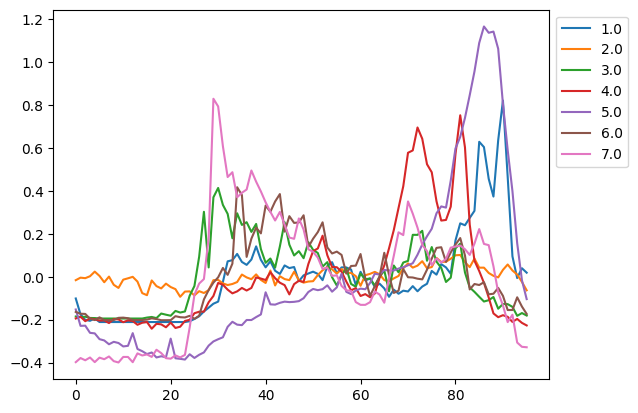

In [155]:
plot_mean_sample(hard_to_clf_uno_dataset[0].features,hard_to_clf_uno_dataset[0].target)

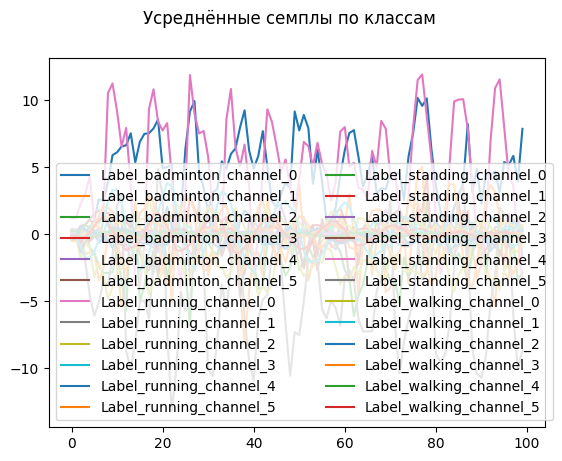

In [145]:
plot_mean_sample_multi(easy_to_clf_multi_dataset[0].features,easy_to_clf_multi_dataset[0].target)

# Transform initial row in feature vector. Easy dataset

In [131]:
stat_pipeline = pipeline_creator.create_pipeline(node_list_model)
feature_extractor = pipeline_creator.create_pipeline(['quantile_extractor'])
feature_matrix = feature_extractor.fit(easy_to_clf_uno_dataset[0])
initial_ts, transformed_ts = pd.DataFrame(feature_matrix.features.squeeze()),pd.DataFrame(feature_matrix.predict.squeeze())
transformed_ts['target'] = feature_matrix.target

In [ ]:
node_dict = {'quantile_extractor':{'window_size':10,
                                   'stride':50}}

In [132]:
transformed_ts.groupby(by='target').first()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
target,,,,,,,,,,,,,,,,,,,,,
1.0,0.199062,-1.086262,3.0,0.074049,0.882922,1.441785,0.958333,0.166667,0.810975,4.220176,...,0.743115,-1.850372e-17,-0.203329,0.978945,1.732495,-1.493878,-1.435400,-0.606625,0.835160,1.409857
2.0,-0.306763,-1.338495,4.0,0.077907,0.776345,1.698066,0.958333,0.166667,0.915196,4.251629,...,0.704191,-4.166667e-10,0.154370,0.978945,1.330520,-1.521644,-1.508412,-0.882112,0.815954,1.292295


In [146]:
result_dict = ApiTemplate(api_config=api_config,
                          metric_list=metric_names).eval(dataset='ItalyPowerDemand',
                                                         finetune=finetune,
                                                         initial_assumption = node_list_model)

2024-10-14 17:12:42,894 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\ItalyPowerDemand
2024-10-14 17:12:42,904 - Data read successfully from local folder
2024-10-14 17:12:42,909 - Initialising experiment setup
2024-10-14 17:12:42,910 - -------------------------------------------------
2024-10-14 17:12:42,911 - Initialising Industrial Repository
2024-10-14 17:12:42,912 - -------------------------------------------------
2024-10-14 17:12:42,912 - Initialising Dask Server
Creating Dask Server
2024-10-14 17:12:42,922 - State start
2024-10-14 17:12:42,934 -   Scheduler at: inproc://10.64.4.172/17848/75
2024-10-14 17:12:42,935 -   dashboard at:  http://10.64.4.172:60191/status
2024-10-14 17:12:42,936 - Registering Worker plugin shuffle
2024-10-14 17:12:42,953 -       Start worker at: inproc://10.64.4.172/17848/78
2024-10-14 17:12:42,957 -          Listening to:          inproc10.64.4.172
2024-10-14 17:12:42,958 -           Worker name:                          0
202

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

IndustrialDispatcher - Number of used CPU's: 2
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness evaluation. Skipping the pipeline. Exception <'list' object has no attribute 'supplementary_data'> on (/n_quantile_extractor_{'window_size': 45, 'stride': 1, 'add_global_features': False};)/n_logit
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness evaluation. Skipping the pipeline. Exception <'list' object has no attribute 'supplementary_data'> on (/n_quantile_extractor_{'window_size': 35, 'stride': 9, 'add_global_features': True};)/n_logit_{'C': 0.08018172582949566, 'penalty': 'l1', 'solver': 'liblinear'}
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness evaluation. Skipping the pipeline. Exception <Expected 2D array, got 1D array instead:
array=[-0.89604071 -0.98161424 -0.64846556 -0.6949193  -0.25805705 -0.97486577
 -1.06441    -1.1454914  -1.07068    -0.40497694 -0.96550567  0.20810137
 -0.5855154  -0.02695228 -0.81286761 -1.04341

Generations:   0%|          | 0/10000 [00:43<?, ?gen/s]

OptimisationTimer - Composition time: 0.718 min
OptimisationTimer - Algorithm was terminated due to processing time limit
IndustrialEvoOptimizer - Generation num: 2 size: 1
IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<accuracy=-0.792 node_number=0.200>']
IndustrialEvoOptimizer - no improvements for 1 iterations
IndustrialEvoOptimizer - spent time: 0.7 min
GPComposer - GP composition finished
DataSourceSplitter - K-folds cross validation is applied.
ApiComposer - Hyperparameters tuning started with 0 min. timeout
SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [logit, quantile_extractor]}
logit - {'C': 0.9004533434023936, 'penalty': 'l2', 'solver': 'liblinear'}
quantile_extractor - {} 
Initial metric: [0.792]
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]2024-10-14 17:13:28,505 - build_posterior_wrapper took 0.011959 seconds
2024-10-14 17:13:28,507 - TPE using 0 trials
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness evaluation. Skipping the pipeline. Exception <'list' object has no attribute 'supplementary_data'> on (/n_quantile_extractor_{'add_global_features': False, 'stride': 8, 'window_size': 5};)/n_logit_{'C': 0.9004533434023936, 'penalty': 'l2', 'solver': 'liblinear'}
 10%|█         | 1/10 [00:00<00:03,  2.43trial/s, best loss: inf]2024-10-14 17:13:28,918 - build_posterior_wrapper took 0.009996 seconds
2024-10-14 17:13:28,924 - TPE using 1/1 trials with best loss inf
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness eva

In [147]:
print(result_dict['metrics'])

   accuracy     f1  precision
0     0.723  0.742      0.728


# Transform initial row in feature vector. Hard dataset

In [156]:
stat_pipeline = pipeline_creator.create_pipeline(node_list_model)
feature_extractor = pipeline_creator.create_pipeline(['quantile_extractor'])
feature_matrix = feature_extractor.fit(hard_to_clf_uno_dataset[0])
initial_ts, transformed_ts = pd.DataFrame(feature_matrix.features.squeeze()),pd.DataFrame(feature_matrix.predict.squeeze())
transformed_ts['target'] = feature_matrix.target

In [160]:
transformed_ts

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,target
0,4.781661,21.857035,2.0,0.004143,0.303948,0.000000,0.989583,0.041667,0.503727,0.498850,...,-1.770833e-09,-0.213938,0.994778,5.585047,-0.213938,-0.213938,-2.139382e-01,-0.213938,0.154251,1.0
1,6.982644,51.614110,1.0,0.004286,0.862304,0.000000,0.989583,0.020833,0.619377,0.333216,...,1.145833e-09,-0.166598,0.994778,8.131040,-0.166598,-0.166598,-1.665976e-01,-0.166598,-0.166598,4.0
2,0.631072,-1.492669,10.0,-0.000874,0.217731,2.014866,0.989583,0.218750,0.544344,2.323477,...,3.333333e-09,-0.783021,0.994778,1.696814,-0.783021,-0.783021,-7.830209e-01,1.231845,1.580572,2.0
3,2.141406,3.358323,6.0,0.018356,0.034031,0.000000,0.989583,0.125000,0.768398,1.151543,...,-5.000000e-09,-0.435438,0.994778,3.662803,-0.435438,-0.435438,-4.354381e-01,-0.435438,2.125963,5.0
4,8.295791,72.098259,1.0,-0.002390,0.864106,0.000000,0.989583,0.020833,0.333090,0.166928,...,-3.125000e-09,-0.133151,0.994778,8.997227,-0.133151,-0.133151,-1.331514e-01,-0.133151,-0.133151,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,5.898298,34.676828,2.0,0.007734,0.866926,0.000000,0.989583,0.020833,0.670338,0.416115,...,-1.135417e-09,-0.180066,0.994778,6.532028,-0.180066,-0.180066,-1.800663e-01,-0.180066,-0.117773,4.0
8922,0.135169,-0.445727,33.0,0.009239,0.517216,1.597863,0.989583,0.458333,-0.037192,4.296933,...,-8.322917e-09,0.094318,0.994778,2.757423,-1.858625,-1.503544,-7.933832e-01,0.804479,1.559026,4.0
8923,-1.173111,-0.637535,23.0,-0.000499,0.140819,0.574335,0.989583,0.489583,-0.333333,0.811278,...,-5.000000e-09,0.574335,0.994778,0.574335,-1.723006,-1.723006,-5.000000e-09,0.574335,0.574335,5.0
8924,6.817212,49.579918,2.0,0.005960,0.859749,0.000000,0.989583,0.020833,0.561447,0.498850,...,7.291667e-10,-0.185983,0.994778,8.019215,-0.185983,-0.185983,-1.859831e-01,-0.185983,0.676157,4.0


In [157]:
transformed_ts.groupby(by='target').first()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
target,,,,,,,,,,,,,,,,,,,,,
1.0,4.781661,21.857035,2.0,0.004143,0.303948,0.000000,0.989583,0.041667,0.503727,0.498850,...,0.885914,-1.770833e-09,-0.213938,0.994778,5.585047,-0.213938,-0.213938,-0.213938,-0.213938,0.154251
2.0,0.631072,-1.492669,10.0,-0.000874,0.217731,2.014866,0.989583,0.218750,0.544344,2.323477,...,0.749433,3.333333e-09,-0.783021,0.994778,1.696814,-0.783021,-0.783021,-0.783021,1.231845,1.580572
3.0,8.295791,72.098259,1.0,-0.002390,0.864106,0.000000,0.989583,0.020833,0.333090,0.166928,...,0.931344,-3.125000e-09,-0.133151,0.994778,8.997227,-0.133151,-0.133151,-0.133151,-0.133151,-0.133151
4.0,6.982644,51.614110,1.0,0.004286,0.862304,0.000000,0.989583,0.020833,0.619377,0.333216,...,0.931344,1.145833e-09,-0.166598,0.994778,8.131040,-0.166598,-0.166598,-0.166598,-0.166598,-0.166598
5.0,2.141406,3.358323,6.0,0.018356,0.034031,0.000000,0.989583,0.125000,0.768398,1.151543,...,0.730208,-5.000000e-09,-0.435438,0.994778,3.662803,-0.435438,-0.435438,-0.435438,-0.435438,2.125963
6.0,6.900998,51.500275,2.0,0.000755,0.874662,0.000000,0.989583,0.041667,0.272347,0.725212,...,0.885914,-1.510417e-09,-0.189545,0.994778,8.182152,-0.189545,-0.189545,-0.189545,-0.189545,0.277471
7.0,0.113258,-1.039021,18.0,0.011574,0.772800,1.886971,0.989583,0.229167,0.777667,3.279687,...,0.634906,7.458333e-09,0.493963,0.994778,2.627060,-1.146882,-1.146882,-1.146882,0.740089,1.416937


In [158]:
result_dict = ApiTemplate(api_config=api_config,
                          metric_list=metric_names).eval(dataset='Phoneme',
                                                         finetune=finetune,
                                                         initial_assumption = node_list_model)

2024-10-14 17:24:46,814 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\Phoneme
2024-10-14 17:24:47,323 - Data read successfully from local folder
2024-10-14 17:24:47,332 - Initialising experiment setup
2024-10-14 17:24:47,337 - -------------------------------------------------
2024-10-14 17:24:47,338 - Initialising Industrial Repository
2024-10-14 17:24:47,339 - -------------------------------------------------
2024-10-14 17:24:47,339 - Initialising Dask Server
Creating Dask Server
2024-10-14 17:24:47,351 - State start
2024-10-14 17:24:47,372 -   Scheduler at: inproc://10.64.4.172/17848/87
2024-10-14 17:24:47,374 -   dashboard at:  http://10.64.4.172:61112/status
2024-10-14 17:24:47,376 - Registering Worker plugin shuffle
2024-10-14 17:24:47,396 -       Start worker at: inproc://10.64.4.172/17848/90
2024-10-14 17:24:47,397 -          Listening to:          inproc10.64.4.172
2024-10-14 17:24:47,398 -           Worker name:                          0
2024-10-14 1

In [159]:
print(result_dict['metrics'])

   accuracy    f1  precision
0     0.262  0.21      0.148


## Классификация с помощью частотных преобразований

In [5]:
EMG = 'NerveDamage'
EEG = 'MotorImagery'
fourier_model = ['fourier_basis', 'quantile_extractor', 'rf']
wavelet_model = ['wavelet_basis', 'quantile_extractor', 'rf']
stat_model = ['quantile_extractor', 'rf']

In [6]:
emg_dataset = pipeline_creator.create_input_data(EMG)
eeg_dataset = pipeline_creator.create_input_data(EEG)

### Fourier Hyperparams

In [7]:
fourier_params = {'threshold': {'hyperopt-dist': hp.choice, 'sampling-scope': [list(np.arange(0.75, 0.99, 0.05))]},
         'low_rank': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 30, 3)]]},
         'approximation': {'hyperopt-dist': hp.choice, 'sampling-scope': [['smooth', 'exact']]},
         'output_format': {'hyperopt-dist': hp.choice, 'sampling-scope': [['signal', 'spectrum']]}
         }

In [8]:
stat_params =  {'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]},
         'add_global_features': {'hyperopt-dist': hp.choice, 'sampling-scope': [[True, False]]}}

In [9]:
wavelet_params = {'n_components': {'hyperopt-dist': hp.uniformint, 'sampling-scope': [2, 10]},
         'wavelet': {'hyperopt-dist': hp.choice,
                     'sampling-scope': [['mexh', 'morl', 'db5', 'sym5']]}}
discrete_wav = DISCRETE_WAVELETS
cont_wat = CONTINUOUS_WAVELETS

In [22]:
threshold =  0.9
output_format = 'spectrum'
approximation = 'smooth'
low_rank = 10
estimator = SPECTRUM_ESTIMATORS['eigen']
wavelet = 'gaus8'
n_components = 5
low_freq = True

In [23]:
fourier_node_dict = {'fourier_basis':{'threshold':threshold,
                                'approximation':approximation,
                              'low_rank':low_rank}}

In [24]:
wavelet_node_dict = {'wavelet_basis':{'wavelet':wavelet,
                                'n_components':n_components,
                                      'low_freq':low_freq}}

In [13]:
feature_extractor = pipeline_creator.create_pipeline(fourier_node_dict)
feature_matrix = feature_extractor.fit(emg_dataset[0])

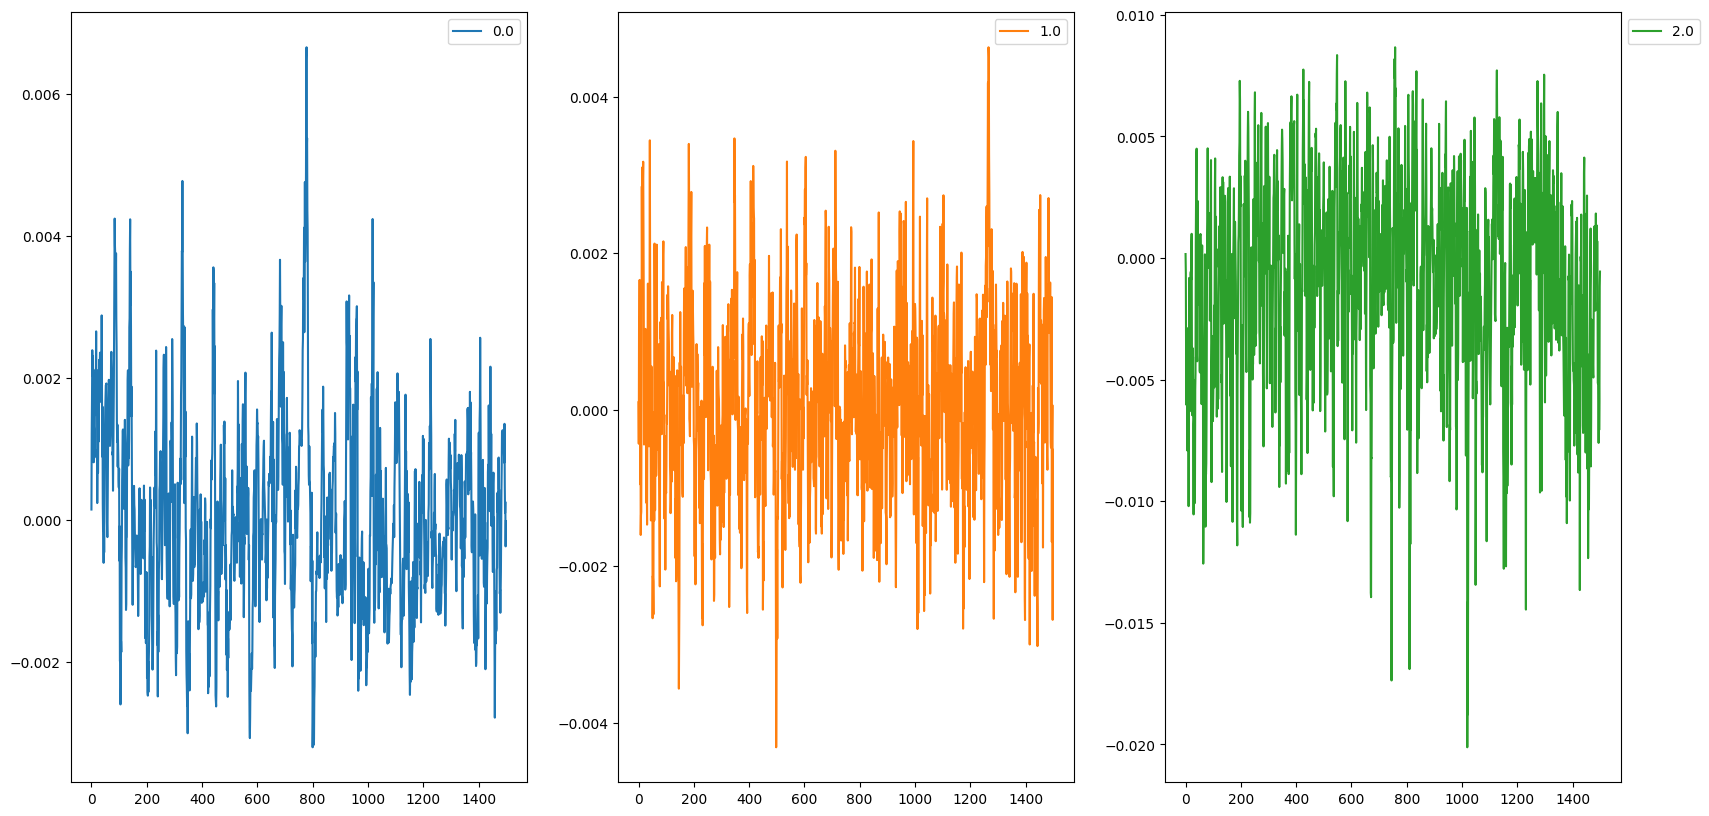

In [14]:
plot_mean_sample(emg_dataset[0].features,emg_dataset[0].target)

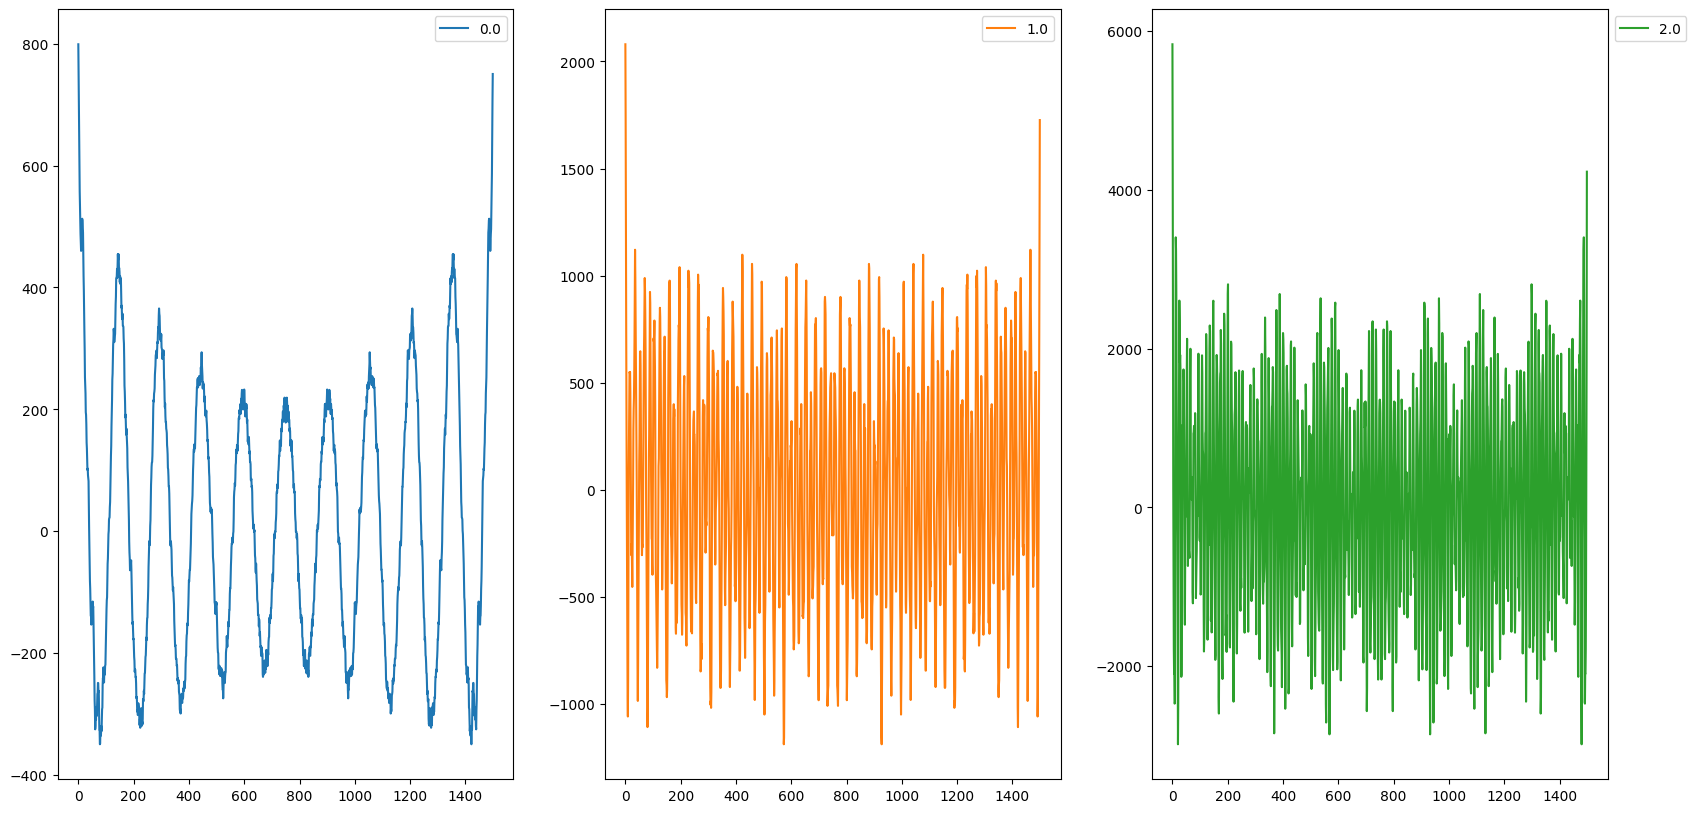

In [15]:
plot_mean_sample(feature_matrix.predict, feature_matrix.target)

In [25]:
feature_extractor = pipeline_creator.create_pipeline(wavelet_node_dict)
feature_matrix = feature_extractor.fit(emg_dataset[0])

In [26]:
n_channels = list(range(feature_matrix.predict.shape[1]))

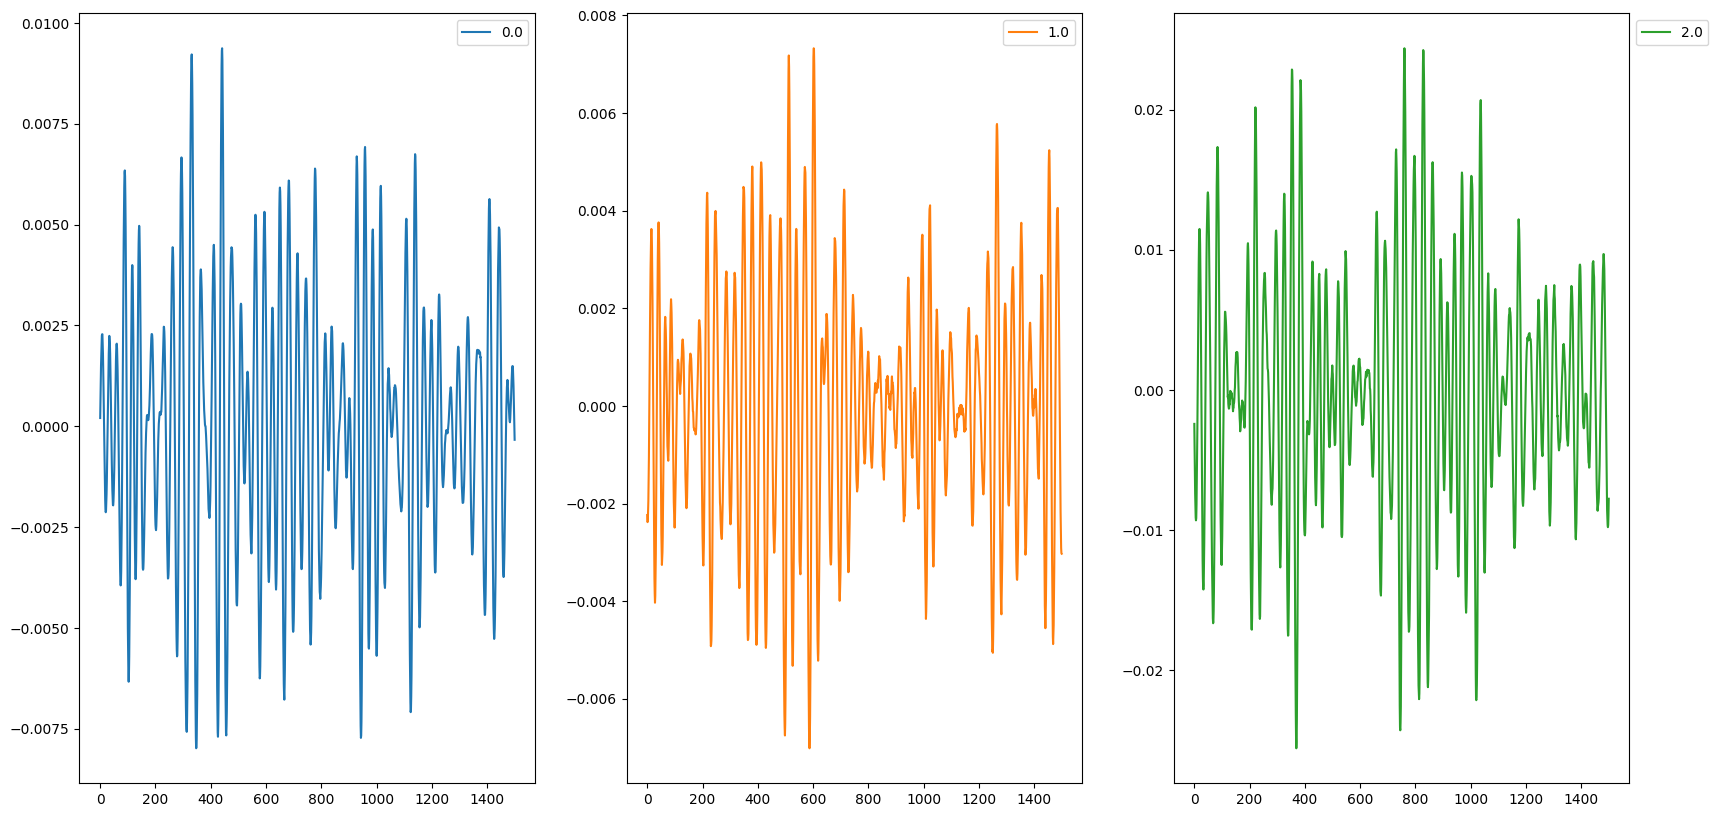

In [27]:
for channel in n_channels:
    y = np.expand_dims(feature_matrix.predict[:,channel,:], axis=1)
    plot_mean_sample(y, feature_matrix.target)

In [265]:
stat_list_model =  {'quantile_extractor':{'window_size':10,
                                             'add_global_features':True,
                                             'use_sliding_window':False},
                       'logit':{}}

In [266]:
result_dict_stat = ApiTemplate(api_config=api_config,
                          metric_list=metric_names).eval(dataset='NerveDamage',
                                                         finetune=finetune,
                                                         initial_assumption = stat_list_model)

2024-10-21 13:13:30,002 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\NerveDamage
2024-10-21 13:13:30,332 - Data read successfully from local folder
2024-10-21 13:13:30,337 - Initialising experiment setup
2024-10-21 13:13:30,368 - -------------------------------------------------
2024-10-21 13:13:30,369 - Initialising Industrial Repository
2024-10-21 13:13:30,370 - -------------------------------------------------
2024-10-21 13:13:30,370 - Initialising Dask Server
Creating Dask Server
2024-10-21 13:13:30,385 - State start
2024-10-21 13:13:30,531 -   Scheduler at: inproc://10.64.4.172/17848/119
2024-10-21 13:13:30,534 -   dashboard at:  http://10.64.4.172:52785/status
2024-10-21 13:13:30,539 - Registering Worker plugin shuffle
2024-10-21 13:13:30,690 -       Start worker at: inproc://10.64.4.172/17848/122
2024-10-21 13:13:30,690 -          Listening to:          inproc10.64.4.172
2024-10-21 13:13:30,691 -           Worker name:                          0
2024-1

In [267]:
result_dict_stat['metrics']

,accuracy,f1,precision
0,1.0,1.0,1.0


In [268]:
fourier_list_model =  {'fourier_basis':{'threshold':threshold,
                                'approximation':approximation,
                              'low_rank':low_rank},
                       'quantile_extractor':{'window_size':10,
                                             'add_global_features':True,
                                             'use_sliding_window':False},
                       'logit':{}}

In [269]:
result_dict_fourier = ApiTemplate(api_config=api_config,
                                    metric_list=metric_names).eval(dataset='NerveDamage',
                                                         finetune=finetune,
                                                         initial_assumption = fourier_list_model)

2024-10-21 13:14:51,008 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\NerveDamage
2024-10-21 13:14:51,336 - Data read successfully from local folder
2024-10-21 13:14:51,341 - Initialising experiment setup
2024-10-21 13:14:51,371 - -------------------------------------------------
2024-10-21 13:14:51,372 - Initialising Industrial Repository
2024-10-21 13:14:51,373 - -------------------------------------------------
2024-10-21 13:14:51,373 - Initialising Dask Server
Creating Dask Server
2024-10-21 13:14:51,385 - State start
2024-10-21 13:14:51,527 -   Scheduler at: inproc://10.64.4.172/17848/127
2024-10-21 13:14:51,528 -   dashboard at:  http://10.64.4.172:52871/status
2024-10-21 13:14:51,529 - Registering Worker plugin shuffle
2024-10-21 13:14:51,667 -       Start worker at: inproc://10.64.4.172/17848/130
2024-10-21 13:14:51,667 -          Listening to:          inproc10.64.4.172
2024-10-21 13:14:51,668 -           Worker name:                          0
2024-1

In [270]:
result_dict_fourier['metrics']

,accuracy,f1,precision
0,0.634,0.639,0.572


In [28]:
wavelet_list_model =  {'wavelet_basis':{'wavelet':wavelet,
                                'n_components':n_components,
                                      'low_freq':low_freq},
                       'quantile_extractor':{'window_size':10,
                                             'add_global_features':True,
                                             'use_sliding_window':False},
                       'logit':{}}

In [ ]:
result_dict_wavelet = ApiTemplate(api_config=api_config,
                                    metric_list=metric_names).eval(dataset='NerveDamage',
                                                         finetune=finetune,
                                                         initial_assumption = wavelet_list_model)

2024-10-21 13:58:21,882 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\NerveDamage
2024-10-21 13:58:22,100 - Data read successfully from local folder
2024-10-21 13:58:22,103 - Initialising experiment setup
2024-10-21 13:58:22,119 - -------------------------------------------------
2024-10-21 13:58:22,120 - Initialising Industrial Repository
2024-10-21 13:58:22,121 - -------------------------------------------------
2024-10-21 13:58:22,121 - Initialising Dask Server
Creating Dask Server
2024-10-21 13:58:22,127 - State start
2024-10-21 13:58:22,264 -   Scheduler at: inproc://10.64.4.172/24900/9
2024-10-21 13:58:22,265 -   dashboard at:  http://10.64.4.172:55502/status
2024-10-21 13:58:22,265 - Registering Worker plugin shuffle
2024-10-21 13:58:22,405 -       Start worker at: inproc://10.64.4.172/24900/12
2024-10-21 13:58:22,405 -          Listening to:          inproc10.64.4.172
2024-10-21 13:58:22,406 -           Worker name:                          0
2024-10-2

In [ ]:
result_dict_wavelet['metrics']